In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from models import Model

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

In [4]:
batch_size = 32
shuffle = True
num_workers = 4

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=train_transform,
                                             download=True)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                               shuffle=shuffle, num_workers=num_workers)

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                              num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
images, labels = next(iter(train_dataloader))

In [7]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(9))

In [8]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
def imshow(img, label=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if label is not None:
        plt.title(train_dataset.classes[label.item()])
    plt.show()

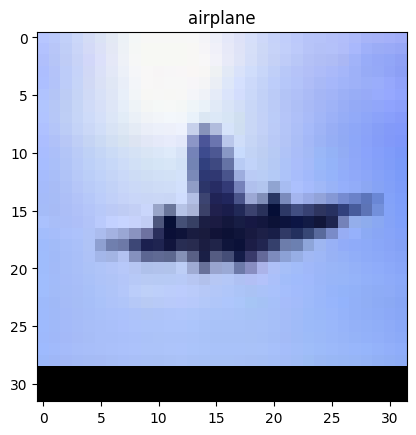

In [10]:
imshow(torchvision.utils.make_grid(tensor=[images[30]]),  label=labels[30])

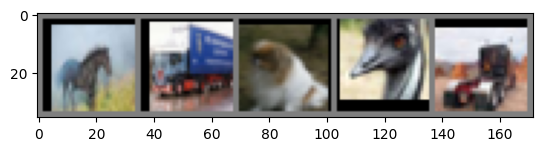

In [11]:
imshow(torchvision.utils.make_grid(images[2:7]))

## BatchNorm

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(normalization="batchnorm").to(device)

summary(model, input_size=(3,32,32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             512
              ReLU-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]           2,304
             ReLU-11           [-1, 16, 16, 16]               0
      BatchNorm2d-12           [-1, 16, 16, 16]              32
           Conv2d-13           [-1, 16, 16, 16]           2,304
             ReLU-14           [-1, 16,

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
    epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
    epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
model =  Model(normalization="batchnorm").to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

EPOCH: 1


Loss=1.940340280532837 Batch_id=1562 Accuracy=44.12: 100%|██████████| 1563/1563 [00:11<00:00, 133.13it/s] 



Test set: Average loss: 1.2032, Accuracy: 5541/10000 (55.41%)

EPOCH: 2


Loss=1.738358974456787 Batch_id=1562 Accuracy=58.28: 100%|██████████| 1563/1563 [00:11<00:00, 133.90it/s] 



Test set: Average loss: 1.0794, Accuracy: 6219/10000 (62.19%)

EPOCH: 3


Loss=1.260515809059143 Batch_id=1562 Accuracy=63.08: 100%|██████████| 1563/1563 [00:11<00:00, 134.07it/s]  



Test set: Average loss: 1.0304, Accuracy: 6380/10000 (63.80%)

EPOCH: 4


Loss=0.8110808730125427 Batch_id=1562 Accuracy=66.47: 100%|██████████| 1563/1563 [00:12<00:00, 123.45it/s] 



Test set: Average loss: 0.8865, Accuracy: 6895/10000 (68.95%)

EPOCH: 5


Loss=1.217529058456421 Batch_id=1562 Accuracy=68.54: 100%|██████████| 1563/1563 [00:11<00:00, 133.11it/s]  



Test set: Average loss: 0.8474, Accuracy: 6980/10000 (69.80%)

EPOCH: 6


Loss=0.3857712149620056 Batch_id=1562 Accuracy=69.88: 100%|██████████| 1563/1563 [00:11<00:00, 132.55it/s] 



Test set: Average loss: 0.8602, Accuracy: 6995/10000 (69.95%)

EPOCH: 7


Loss=0.7053514719009399 Batch_id=1562 Accuracy=71.06: 100%|██████████| 1563/1563 [00:11<00:00, 133.04it/s] 



Test set: Average loss: 0.8484, Accuracy: 7033/10000 (70.33%)

EPOCH: 8


Loss=1.2748866081237793 Batch_id=1562 Accuracy=72.13: 100%|██████████| 1563/1563 [00:11<00:00, 131.33it/s] 



Test set: Average loss: 0.7913, Accuracy: 7271/10000 (72.71%)

EPOCH: 9


Loss=0.37940356135368347 Batch_id=1562 Accuracy=72.92: 100%|██████████| 1563/1563 [00:12<00:00, 122.96it/s]



Test set: Average loss: 0.7546, Accuracy: 7400/10000 (74.00%)

EPOCH: 10


Loss=0.6849818229675293 Batch_id=1562 Accuracy=73.51: 100%|██████████| 1563/1563 [00:11<00:00, 131.66it/s] 



Test set: Average loss: 0.7266, Accuracy: 7429/10000 (74.29%)

EPOCH: 11


Loss=0.8589004278182983 Batch_id=1562 Accuracy=74.22: 100%|██████████| 1563/1563 [00:11<00:00, 131.86it/s] 



Test set: Average loss: 0.7579, Accuracy: 7405/10000 (74.05%)

EPOCH: 12


Loss=0.5849279761314392 Batch_id=1562 Accuracy=74.45: 100%|██████████| 1563/1563 [00:11<00:00, 132.66it/s] 



Test set: Average loss: 0.7097, Accuracy: 7524/10000 (75.24%)

EPOCH: 13


Loss=0.5214086174964905 Batch_id=1562 Accuracy=74.93: 100%|██████████| 1563/1563 [00:11<00:00, 130.25it/s] 



Test set: Average loss: 0.7214, Accuracy: 7559/10000 (75.59%)

EPOCH: 14


Loss=0.6295583844184875 Batch_id=1562 Accuracy=75.47: 100%|██████████| 1563/1563 [00:12<00:00, 125.45it/s] 



Test set: Average loss: 0.6973, Accuracy: 7624/10000 (76.24%)

EPOCH: 15


Loss=0.6634907722473145 Batch_id=1562 Accuracy=75.76: 100%|██████████| 1563/1563 [00:11<00:00, 131.03it/s] 



Test set: Average loss: 0.7596, Accuracy: 7403/10000 (74.03%)

EPOCH: 16


Loss=0.8517518639564514 Batch_id=1562 Accuracy=76.16: 100%|██████████| 1563/1563 [00:11<00:00, 131.63it/s] 



Test set: Average loss: 0.7706, Accuracy: 7329/10000 (73.29%)

EPOCH: 17


Loss=0.7626058459281921 Batch_id=1562 Accuracy=76.48: 100%|██████████| 1563/1563 [00:12<00:00, 130.03it/s] 



Test set: Average loss: 0.7320, Accuracy: 7507/10000 (75.07%)

EPOCH: 18


Loss=0.5712152719497681 Batch_id=1562 Accuracy=76.43: 100%|██████████| 1563/1563 [00:12<00:00, 129.24it/s] 



Test set: Average loss: 0.7142, Accuracy: 7573/10000 (75.73%)

EPOCH: 19


Loss=0.8273822665214539 Batch_id=1562 Accuracy=76.93: 100%|██████████| 1563/1563 [00:12<00:00, 125.75it/s] 



Test set: Average loss: 0.7361, Accuracy: 7552/10000 (75.52%)

EPOCH: 20


Loss=0.7374616861343384 Batch_id=1562 Accuracy=77.30: 100%|██████████| 1563/1563 [00:11<00:00, 131.89it/s] 



Test set: Average loss: 0.7845, Accuracy: 7378/10000 (73.78%)



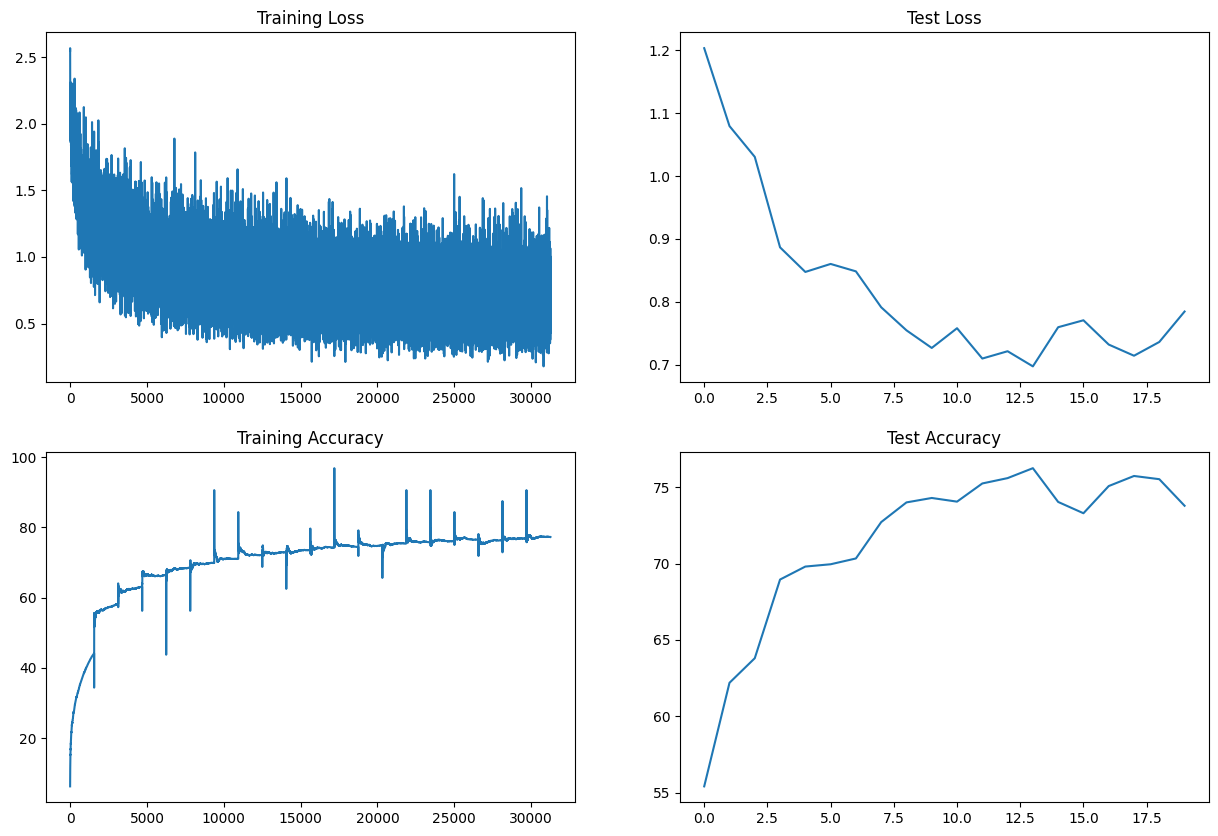

In [15]:
from utils import plot_metric_curves

plot_metric_curves(train_losses, train_acc, test_losses, test_acc)

### Misclassified Images 

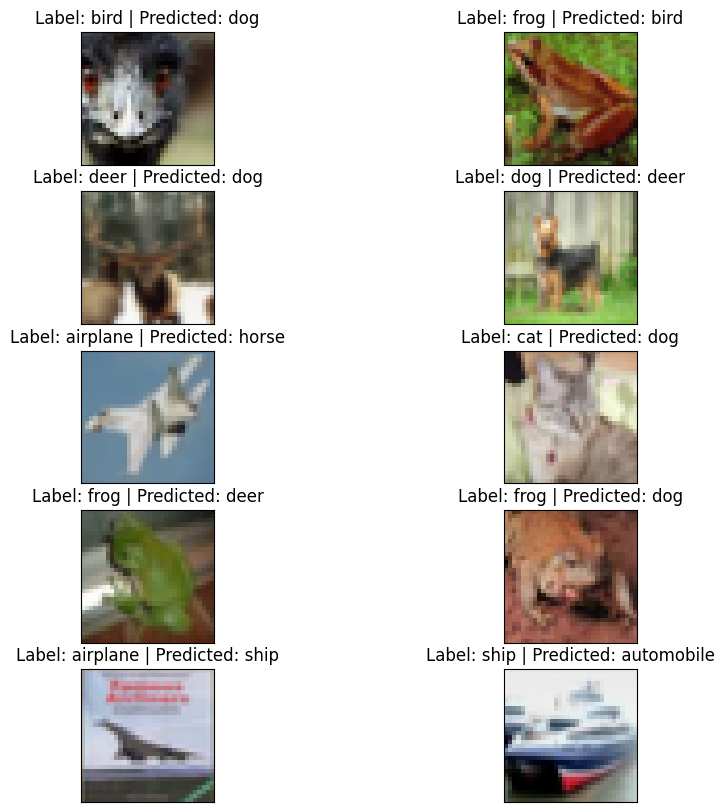

In [16]:
from utils import plot_misclassified

plot_misclassified(model, test_dataloader, device)

## GroupNorm

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(normalization="groupnorm").to(device)

summary(model, input_size=(3,32,32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
         GroupNorm-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             512
              ReLU-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]           2,304
             ReLU-11           [-1, 16, 16, 16]               0
        GroupNorm-12           [-1, 16, 16, 16]              32
           Conv2d-13           [-1, 16, 16, 16]           2,304
             ReLU-14           [-1, 16,

In [18]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []

In [19]:
model =  Model(normalization="groupnorm").to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

EPOCH: 1


Loss=1.5252959728240967 Batch_id=1562 Accuracy=35.23: 100%|██████████| 1563/1563 [00:12<00:00, 128.00it/s]



Test set: Average loss: 1.4992, Accuracy: 4387/10000 (43.87%)

EPOCH: 2


Loss=1.1954166889190674 Batch_id=1562 Accuracy=50.92: 100%|██████████| 1563/1563 [00:12<00:00, 127.51it/s]



Test set: Average loss: 1.2791, Accuracy: 5308/10000 (53.08%)

EPOCH: 3


Loss=1.0647352933883667 Batch_id=1562 Accuracy=57.29: 100%|██████████| 1563/1563 [00:13<00:00, 119.86it/s]



Test set: Average loss: 1.2585, Accuracy: 5544/10000 (55.44%)

EPOCH: 4


Loss=1.3502724170684814 Batch_id=1562 Accuracy=61.19: 100%|██████████| 1563/1563 [00:12<00:00, 127.78it/s]



Test set: Average loss: 1.0735, Accuracy: 6132/10000 (61.32%)

EPOCH: 5


Loss=0.7374464869499207 Batch_id=1562 Accuracy=63.29: 100%|██████████| 1563/1563 [00:12<00:00, 127.81it/s]



Test set: Average loss: 1.1529, Accuracy: 5989/10000 (59.89%)

EPOCH: 6


Loss=0.7482442259788513 Batch_id=1562 Accuracy=64.96: 100%|██████████| 1563/1563 [00:12<00:00, 128.96it/s] 



Test set: Average loss: 1.0237, Accuracy: 6334/10000 (63.34%)

EPOCH: 7


Loss=0.6759799122810364 Batch_id=1562 Accuracy=66.27: 100%|██████████| 1563/1563 [00:11<00:00, 138.73it/s] 



Test set: Average loss: 1.0507, Accuracy: 6301/10000 (63.01%)

EPOCH: 8


Loss=0.8076961636543274 Batch_id=1562 Accuracy=67.60: 100%|██████████| 1563/1563 [00:11<00:00, 130.88it/s] 



Test set: Average loss: 0.9328, Accuracy: 6702/10000 (67.02%)

EPOCH: 9


Loss=1.292290210723877 Batch_id=1562 Accuracy=68.40: 100%|██████████| 1563/1563 [00:13<00:00, 119.45it/s]  



Test set: Average loss: 0.9785, Accuracy: 6568/10000 (65.68%)

EPOCH: 10


Loss=0.8105674386024475 Batch_id=1562 Accuracy=69.30: 100%|██████████| 1563/1563 [00:12<00:00, 130.21it/s] 



Test set: Average loss: 0.9093, Accuracy: 6789/10000 (67.89%)

EPOCH: 11


Loss=1.1535193920135498 Batch_id=1562 Accuracy=70.31: 100%|██████████| 1563/1563 [00:12<00:00, 129.13it/s] 



Test set: Average loss: 0.9323, Accuracy: 6744/10000 (67.44%)

EPOCH: 12


Loss=0.8079776167869568 Batch_id=1562 Accuracy=71.35: 100%|██████████| 1563/1563 [00:12<00:00, 128.37it/s] 



Test set: Average loss: 0.8526, Accuracy: 6911/10000 (69.11%)

EPOCH: 13


Loss=0.5243783593177795 Batch_id=1562 Accuracy=71.85: 100%|██████████| 1563/1563 [00:12<00:00, 129.06it/s] 



Test set: Average loss: 0.8626, Accuracy: 7013/10000 (70.13%)

EPOCH: 14


Loss=0.6156241297721863 Batch_id=1562 Accuracy=72.71: 100%|██████████| 1563/1563 [00:11<00:00, 132.72it/s] 



Test set: Average loss: 0.8280, Accuracy: 7110/10000 (71.10%)

EPOCH: 15


Loss=1.1924337148666382 Batch_id=1562 Accuracy=73.05: 100%|██████████| 1563/1563 [00:11<00:00, 135.65it/s] 



Test set: Average loss: 0.9115, Accuracy: 6844/10000 (68.44%)

EPOCH: 16


Loss=0.5146306157112122 Batch_id=1562 Accuracy=73.14: 100%|██████████| 1563/1563 [00:11<00:00, 134.87it/s] 



Test set: Average loss: 0.7819, Accuracy: 7262/10000 (72.62%)

EPOCH: 17


Loss=1.0976613759994507 Batch_id=1562 Accuracy=73.67: 100%|██████████| 1563/1563 [00:11<00:00, 130.31it/s] 



Test set: Average loss: 0.8263, Accuracy: 7153/10000 (71.53%)

EPOCH: 18


Loss=0.7228060364723206 Batch_id=1562 Accuracy=74.57: 100%|██████████| 1563/1563 [00:11<00:00, 132.05it/s] 



Test set: Average loss: 0.7849, Accuracy: 7252/10000 (72.52%)

EPOCH: 19


Loss=1.0332180261611938 Batch_id=1562 Accuracy=74.78: 100%|██████████| 1563/1563 [00:11<00:00, 134.82it/s] 



Test set: Average loss: 0.7609, Accuracy: 7343/10000 (73.43%)

EPOCH: 20


Loss=0.9862879514694214 Batch_id=1562 Accuracy=75.09: 100%|██████████| 1563/1563 [00:11<00:00, 132.54it/s] 



Test set: Average loss: 0.7158, Accuracy: 7526/10000 (75.26%)



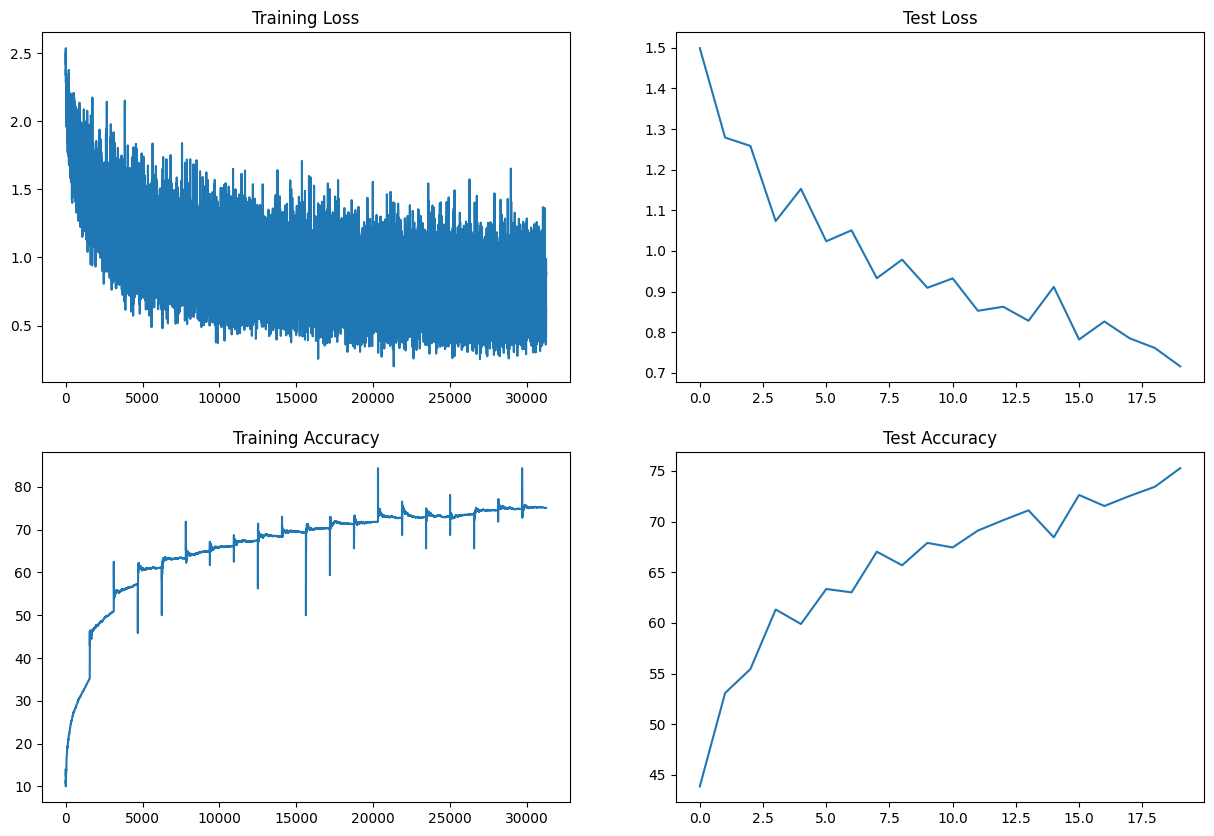

In [20]:
plot_metric_curves(train_losses, train_acc, test_losses, test_acc)

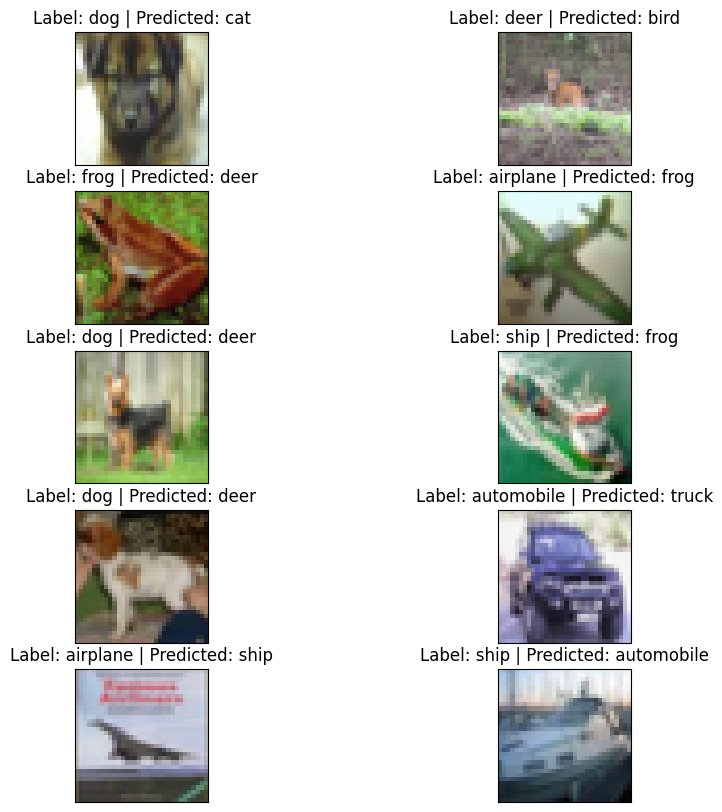

In [21]:
plot_misclassified(model, test_dataloader, device)

## LayerNorm

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(normalization="layernorm").to(device)

summary(model, input_size=(3,32,32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
         GroupNorm-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             512
              ReLU-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]           2,304
             ReLU-11           [-1, 16, 16, 16]               0
        GroupNorm-12           [-1, 16, 16, 16]              32
           Conv2d-13           [-1, 16, 16, 16]           2,304
             ReLU-14           [-1, 16,

In [23]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []

In [24]:
model =  Model(normalization="layernorm").to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

EPOCH: 1


Loss=1.5152736902236938 Batch_id=1562 Accuracy=33.01: 100%|██████████| 1563/1563 [00:12<00:00, 122.76it/s]



Test set: Average loss: 1.4948, Accuracy: 4505/10000 (45.05%)

EPOCH: 2


Loss=0.9555215835571289 Batch_id=1562 Accuracy=49.41: 100%|██████████| 1563/1563 [00:11<00:00, 132.10it/s]



Test set: Average loss: 1.2697, Accuracy: 5288/10000 (52.88%)

EPOCH: 3


Loss=0.8537186980247498 Batch_id=1562 Accuracy=56.05: 100%|██████████| 1563/1563 [00:11<00:00, 132.07it/s]



Test set: Average loss: 1.2301, Accuracy: 5523/10000 (55.23%)

EPOCH: 4


Loss=0.8859081864356995 Batch_id=1562 Accuracy=59.80: 100%|██████████| 1563/1563 [00:11<00:00, 132.94it/s]



Test set: Average loss: 1.2259, Accuracy: 5784/10000 (57.84%)

EPOCH: 5


Loss=1.1795388460159302 Batch_id=1562 Accuracy=62.21: 100%|██████████| 1563/1563 [00:11<00:00, 133.28it/s]



Test set: Average loss: 1.0817, Accuracy: 6152/10000 (61.52%)

EPOCH: 6


Loss=0.9077790975570679 Batch_id=1562 Accuracy=64.52: 100%|██████████| 1563/1563 [00:12<00:00, 124.56it/s] 



Test set: Average loss: 1.1323, Accuracy: 5993/10000 (59.93%)

EPOCH: 7


Loss=1.0268176794052124 Batch_id=1562 Accuracy=65.97: 100%|██████████| 1563/1563 [00:11<00:00, 133.97it/s]



Test set: Average loss: 0.9649, Accuracy: 6588/10000 (65.88%)

EPOCH: 8


Loss=1.1484835147857666 Batch_id=1562 Accuracy=67.34: 100%|██████████| 1563/1563 [00:11<00:00, 135.23it/s] 



Test set: Average loss: 1.0639, Accuracy: 6283/10000 (62.83%)

EPOCH: 9


Loss=1.1038951873779297 Batch_id=1562 Accuracy=68.58: 100%|██████████| 1563/1563 [00:11<00:00, 135.43it/s] 



Test set: Average loss: 0.9725, Accuracy: 6610/10000 (66.10%)

EPOCH: 10


Loss=0.8122692704200745 Batch_id=1562 Accuracy=69.12: 100%|██████████| 1563/1563 [00:11<00:00, 134.09it/s] 



Test set: Average loss: 0.9901, Accuracy: 6501/10000 (65.01%)

EPOCH: 11


Loss=0.9496303796768188 Batch_id=1562 Accuracy=70.16: 100%|██████████| 1563/1563 [00:12<00:00, 125.22it/s] 



Test set: Average loss: 0.9048, Accuracy: 6855/10000 (68.55%)

EPOCH: 12


Loss=0.9987391233444214 Batch_id=1562 Accuracy=70.81: 100%|██████████| 1563/1563 [00:11<00:00, 132.89it/s] 



Test set: Average loss: 0.8673, Accuracy: 6958/10000 (69.58%)

EPOCH: 13


Loss=1.0778323411941528 Batch_id=1562 Accuracy=71.62: 100%|██████████| 1563/1563 [00:11<00:00, 135.43it/s] 



Test set: Average loss: 0.8657, Accuracy: 7065/10000 (70.65%)

EPOCH: 14


Loss=1.1270359754562378 Batch_id=1562 Accuracy=72.46: 100%|██████████| 1563/1563 [00:11<00:00, 134.54it/s] 



Test set: Average loss: 0.9134, Accuracy: 6823/10000 (68.23%)

EPOCH: 15


Loss=0.45361122488975525 Batch_id=1562 Accuracy=72.92: 100%|██████████| 1563/1563 [00:11<00:00, 135.10it/s]



Test set: Average loss: 0.8536, Accuracy: 7022/10000 (70.22%)

EPOCH: 16


Loss=0.7592090964317322 Batch_id=1562 Accuracy=73.56: 100%|██████████| 1563/1563 [00:12<00:00, 125.74it/s] 



Test set: Average loss: 0.9400, Accuracy: 6882/10000 (68.82%)

EPOCH: 17


Loss=0.611943781375885 Batch_id=1562 Accuracy=73.80: 100%|██████████| 1563/1563 [00:11<00:00, 136.00it/s]  



Test set: Average loss: 0.8216, Accuracy: 7139/10000 (71.39%)

EPOCH: 18


Loss=0.47990989685058594 Batch_id=1562 Accuracy=74.31: 100%|██████████| 1563/1563 [00:11<00:00, 134.13it/s]



Test set: Average loss: 0.8709, Accuracy: 6964/10000 (69.64%)

EPOCH: 19


Loss=0.8805761933326721 Batch_id=1562 Accuracy=74.84: 100%|██████████| 1563/1563 [00:11<00:00, 133.08it/s] 



Test set: Average loss: 0.8533, Accuracy: 7104/10000 (71.04%)

EPOCH: 20


Loss=0.7107566595077515 Batch_id=1562 Accuracy=75.26: 100%|██████████| 1563/1563 [00:11<00:00, 133.49it/s] 



Test set: Average loss: 0.8169, Accuracy: 7207/10000 (72.07%)



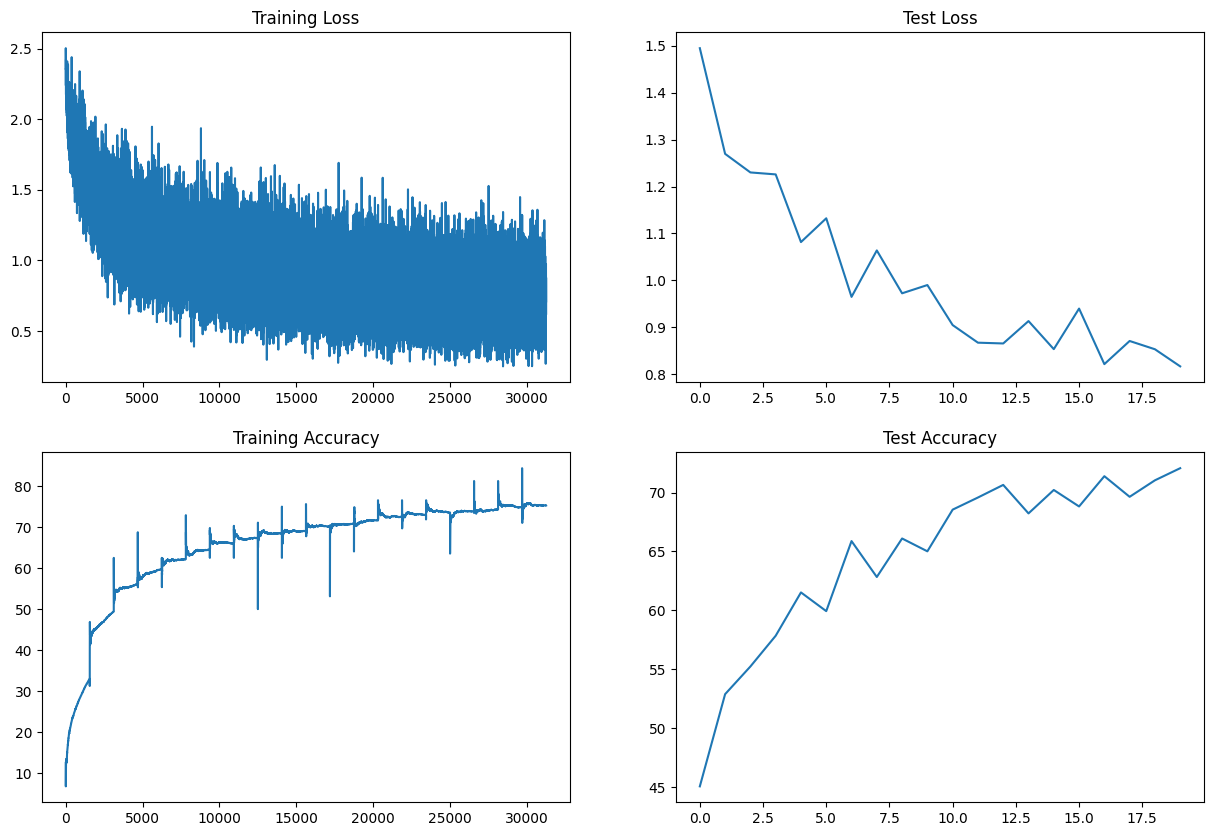

In [25]:
plot_metric_curves(train_losses, train_acc, test_losses, test_acc)

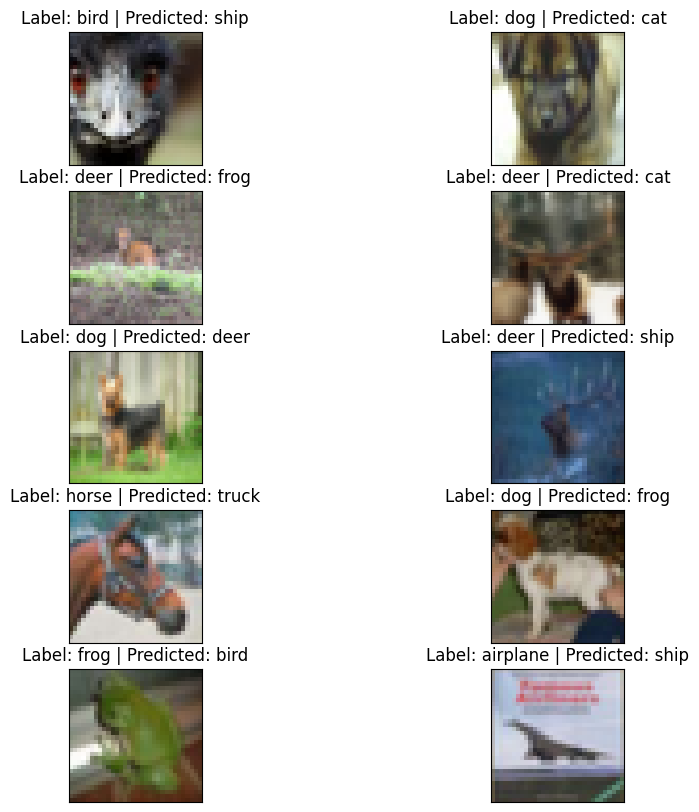

In [26]:
plot_misclassified(model, test_dataloader, device)